In [1]:
!rm rs.txt vs.txt pressure.txt
!nvcc -Werror all-warnings mc.cu -o mc
!./mc

/home/w/miniconda3/bin/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_catch_exception@GLIBC_PRIVATE'
/home/w/miniconda3/bin/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_symbind_alt@GLIBC_PRIVATE'
/home/w/miniconda3/bin/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_preinit@GLIBC_PRIVATE'
/home/w/miniconda3/bin/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_find_dso_for_object@GLIBC_PRIVATE'
/home/w/miniconda3/bin/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__tunable_is_initialized@GLIBC_PRIVATE'
/home/w/miniconda3/bin/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__nptl_change_stack_perm@GLIBC_PRIVATE'
/home/w/miniconda3/bin/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_signal_error@GLIBC_PRIVATE'
/home/w/miniconda3/bin/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__tunable_get_val@GLIBC_PRIVATE'
/home/w/miniconda3/bin/ld: /lib/x86_64-

In [5]:
!du -h rs.txt vs.txt pressure.txt

'du' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [1]:
import numpy as np
import pandas as pd
ls = open('ls.txt', 'r').readlines()
ls = [l.split() for l in ls]
ls = np.array(ls, dtype=int)
print(ls.shape)
print(ls[16**3-1])
print(ls[16**3*2-1])

(16384, 128)
[  6075  17357   9654  11783  17879  15761  12766  36382  23369  44005
  45257  47697  56459  55748  56353  50901  62137  68932  68935  80869
  79355  73274  80915  87245  86232  90972  90652  82234  98009  95224
 106059 106791 107525 122619      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]
[ 17879  45257 107525  86232 106059  80915  98009  36382  15761 122619
  6893

t_stop = 5000.0, mass = 200.0, T = 1.0
rs (131072, 3)
vs (131072, 3)


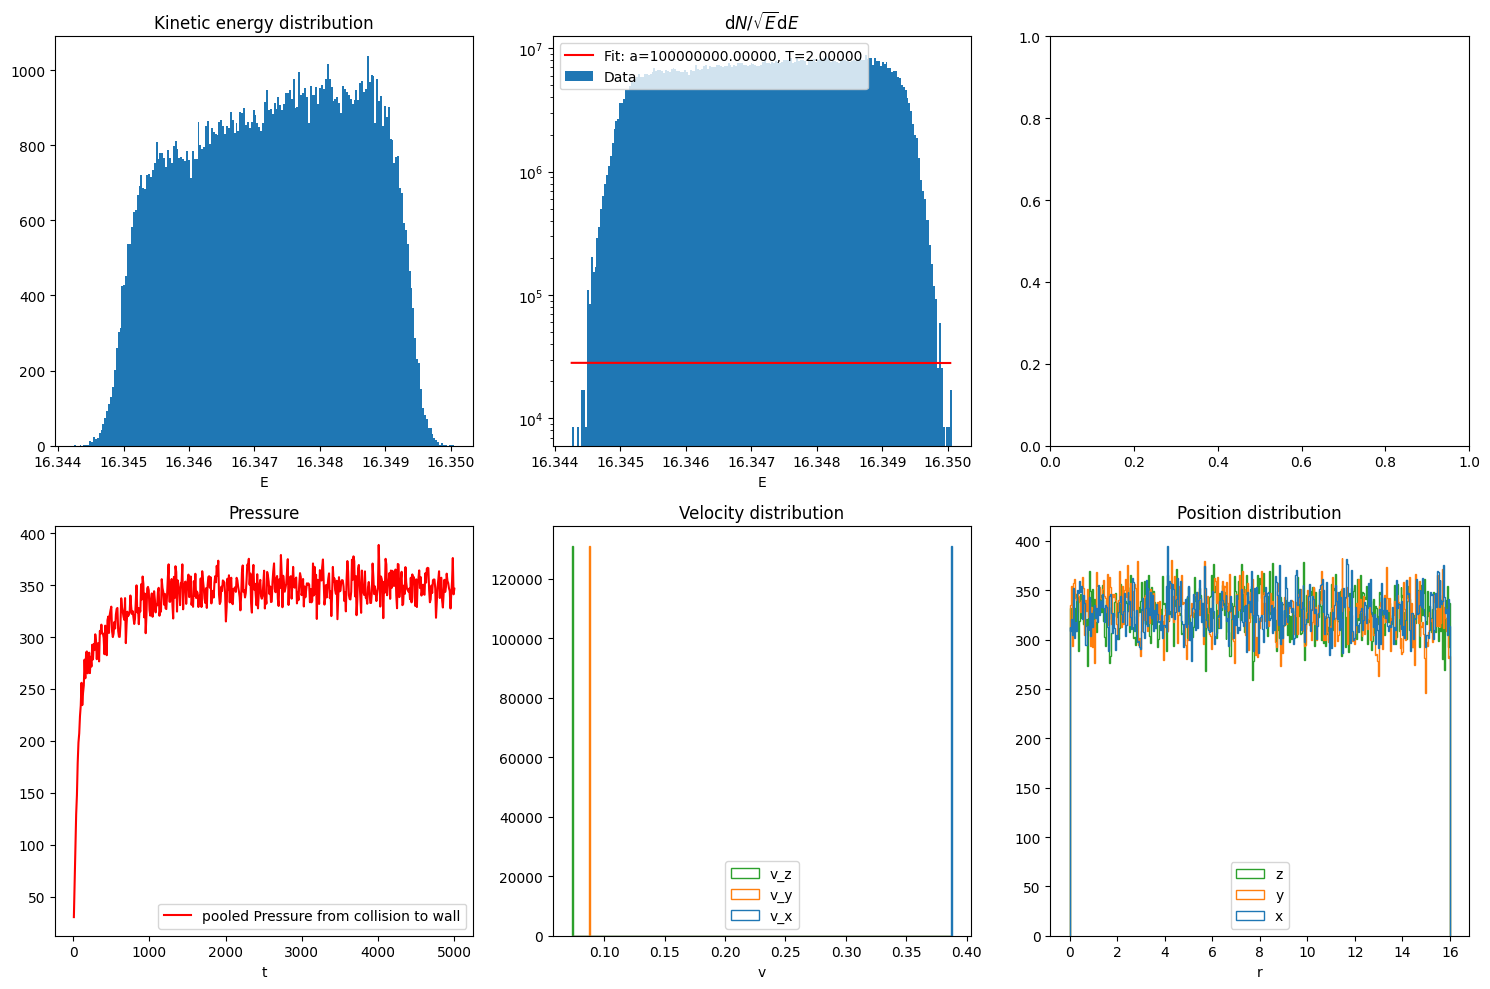

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rs = pd.read_csv('rs.txt', header=None)
vs = pd.read_csv('vs.txt', header=None)
ps = pd.read_csv('pressure.txt', header=None)


from scipy.optimize import curve_fit

para_lines = open('mc.h', 'r').readlines()
t_stop = None
mass = None
T = None
for line in para_lines:
    if line.startswith('#define T_STOP '):
        t_stop = float(line.split()[-1])
    if line.startswith('#define MASS '):
        mass = float(line.split()[-1])
    if line.startswith('#define TEMPERATURE '):
        T = float(line.split()[-1])
print(f't_stop = {t_stop}, mass = {mass}, T = {T}')
rs = np.array(rs, dtype=np.float64)
rs = rs[~np.isnan(rs).any(axis=1)]
print('rs', rs.shape)
vs = np.array(vs, dtype=np.float64)
vs = vs[~np.isnan(vs).any(axis=1)]
vs = vs[~np.isinf(vs).any(axis=1)]
print('vs', vs.shape)
pressures = np.array(ps, dtype=np.float64)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
# ax[0,0].scatter(np.linspace(0, t_stop, len(self.collision_mean_rates_o0)), self.collision_mean_rates_o0, s=1)
# ax[0,0].set_title("Collision mean rates order 0")
# ax[0,0].set_xlabel("t")
# ax[0,1].scatter(np.linspace(0, t_stop, len(self.collision_mean_rates_o1)), self.collision_mean_rates_o1, s=1)
# ax[0,1].set_title("Collision mean rates order 1")
# ax[0,1].set_xlabel("t")
# ax[0,2].scatter(np.linspace(0, t_stop, len(self.collision_mean_rates_o2)), self.collision_mean_rates_o2, s=1)
# ax[0,2].set_title("Collision mean rates order 2")
# ax[0,2].set_xlabel("t")
ax[0,0].hist(0.5 * mass * np.sum(vs ** 2, axis=1), bins=200)
ax[0,0].set_title("Kinetic energy distribution")
ax[0,0].set_xlabel("E")
particle_energies = 0.5 * mass * np.sum(vs ** 2, axis=1)
def exp_func(x, a, temp):
    return a * np.exp(-x/temp)
hist, bins = np.histogram(particle_energies[~np.isnan(particle_energies)], bins=200)
bin_widths = np.diff(bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
norm_factor = bin_widths * np.sqrt(bin_centers)
normalized_hist = hist / norm_factor
popt, pcov = curve_fit(exp_func, bin_centers, normalized_hist, bounds=([0, 0], [1e8, 2*T]))
fit_values = exp_func(bin_centers, *popt)
ax[0,1].bar(bin_centers, normalized_hist, width=bin_widths, align='edge', label='Data')
ax[0,1].plot(bin_centers, fit_values, 'r-', label='Fit: a=%.5f, T=%.5f' % tuple(popt))
ax[0,1].set_yscale('log')
ax[0,1].set_title(R"$\mathrm{d}N/\sqrt{E}\mathrm{d}E$")
ax[0,1].set_xlabel("E")
ax[0,1].legend()
# ax[0,2].scatter(np.linspace(0, t_stop, len(self.Eks)), self.Eks, s=1)
# ax[0,2].set_title("Kinetic energy")
# ax[0,2].set_xlabel("t")
ax[1,0].set_title("Pressure")
# ax[1,0].scatter(np.linspace(0, t_stop, len(pressures)), pressures, s=0.3, label='Pressure')
Ps = []
meaning = 1000
for i in range(0, len(pressures), meaning):
    Ps.append(np.mean(pressures[i:i+meaning]))
Ps.pop()
ax[1,0].plot(np.linspace(t_stop/len(Ps), t_stop, len(Ps)), np.array(Ps), 'r', label='pooled Pressure from collision to wall')
ax[1,0].set_xlabel("t")
ax[1,0].legend()
# ax[1,0].set_yscale('log')
ax[1,1].hist([vs[:,0], vs[:,1], vs[:,2]], bins=400, histtype='step', label=['v_x', 'v_y', 'v_z'])
ax[1,1].set_title("Velocity distribution")
ax[1,1].set_xlabel("v")
ax[1,1].legend()
ax[1,2].hist([rs[:,0], rs[:,1], rs[:,2]], bins=400, histtype='step', label=['x', 'y', 'z'])
ax[1,2].set_title("Position distribution")
ax[1,2].set_xlabel("r")
ax[1,2].legend()
fig.tight_layout()
plt.show()

In [4]:
np.histogram(particle_energies[~np.isnan(particle_energies)], bins=200)
particle_energies[~np.isnan(particle_energies)].shape

(131072,)

In [5]:
np.mean(pressures[-1000:])

np.float64(330.96184510000006)

In [6]:
32/(1-np.pi*0.2**3*32*2/3)

68.99007208861302

In [7]:
rs

array([[11.0856 , 15.0273 ,  6.95655],
       [ 5.09431, 15.6464 , 10.6029 ],
       [ 6.93115,  3.41985, 13.2563 ],
       ...,
       [ 3.21225,  2.83971, 14.3651 ],
       [ 9.8383 ,  5.30329,  8.57438],
       [12.0969 ,  9.28804,  7.13652]])

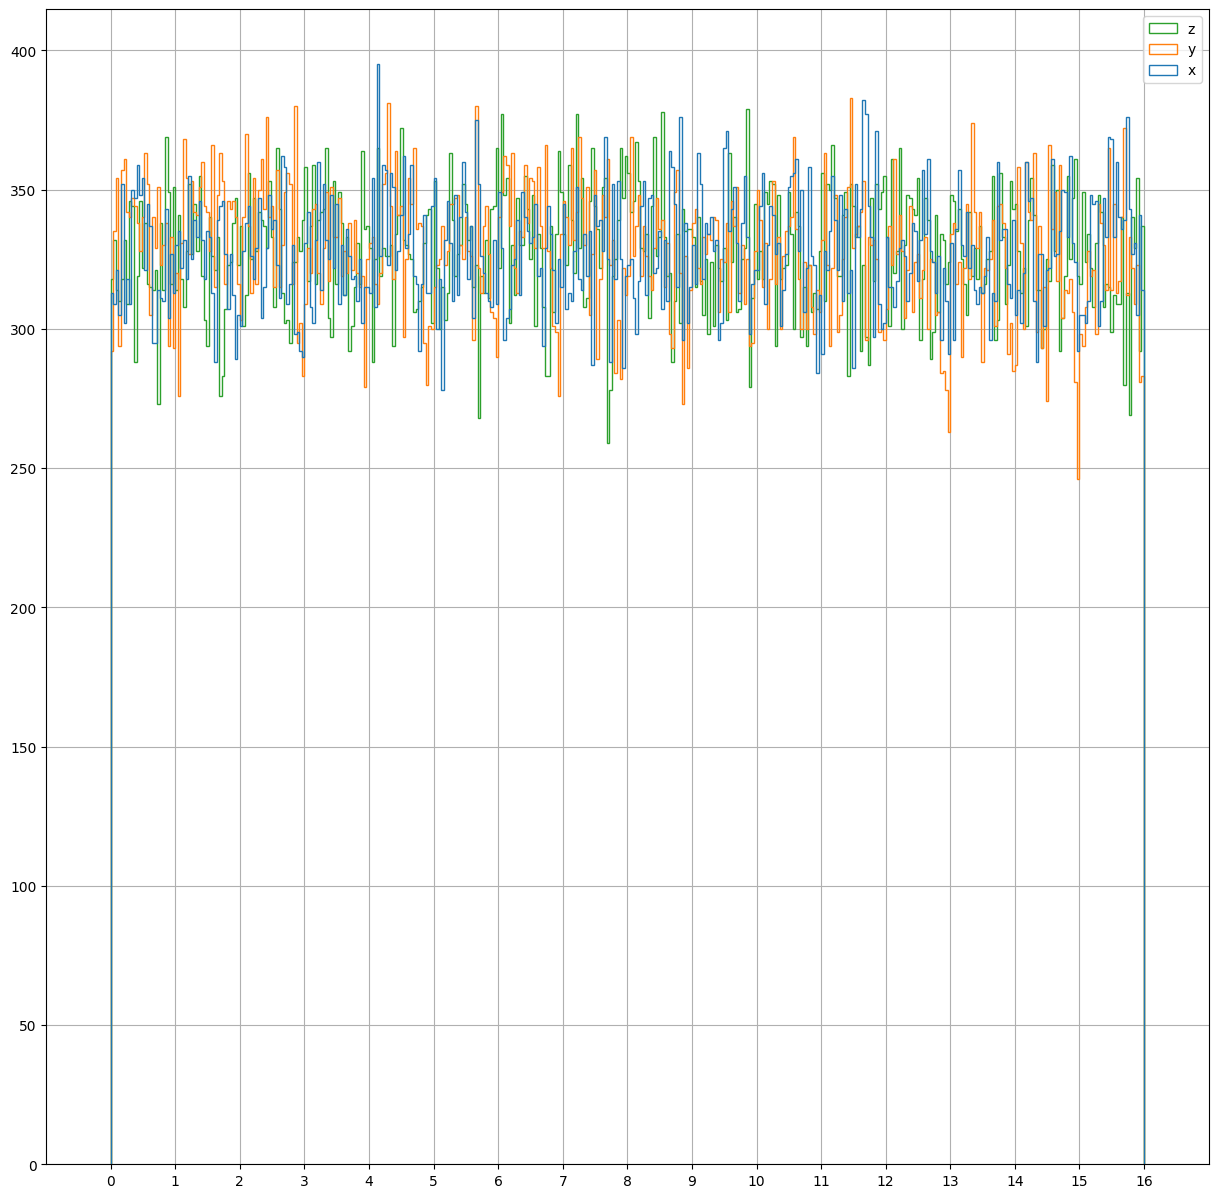

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
# rs = rs[(0<rs<16).any(1)]
# print(rs.shape)
plt.hist([rs[:,0], rs[:,1], rs[:,2]], bins=400, histtype='step', label=['x', 'y', 'z'])
plt.xticks([_ for _ in range(17)])
plt.xlim(-1, 17)
plt.legend()
plt.grid()
plt.show()

(131072, 3) (131072, 3)


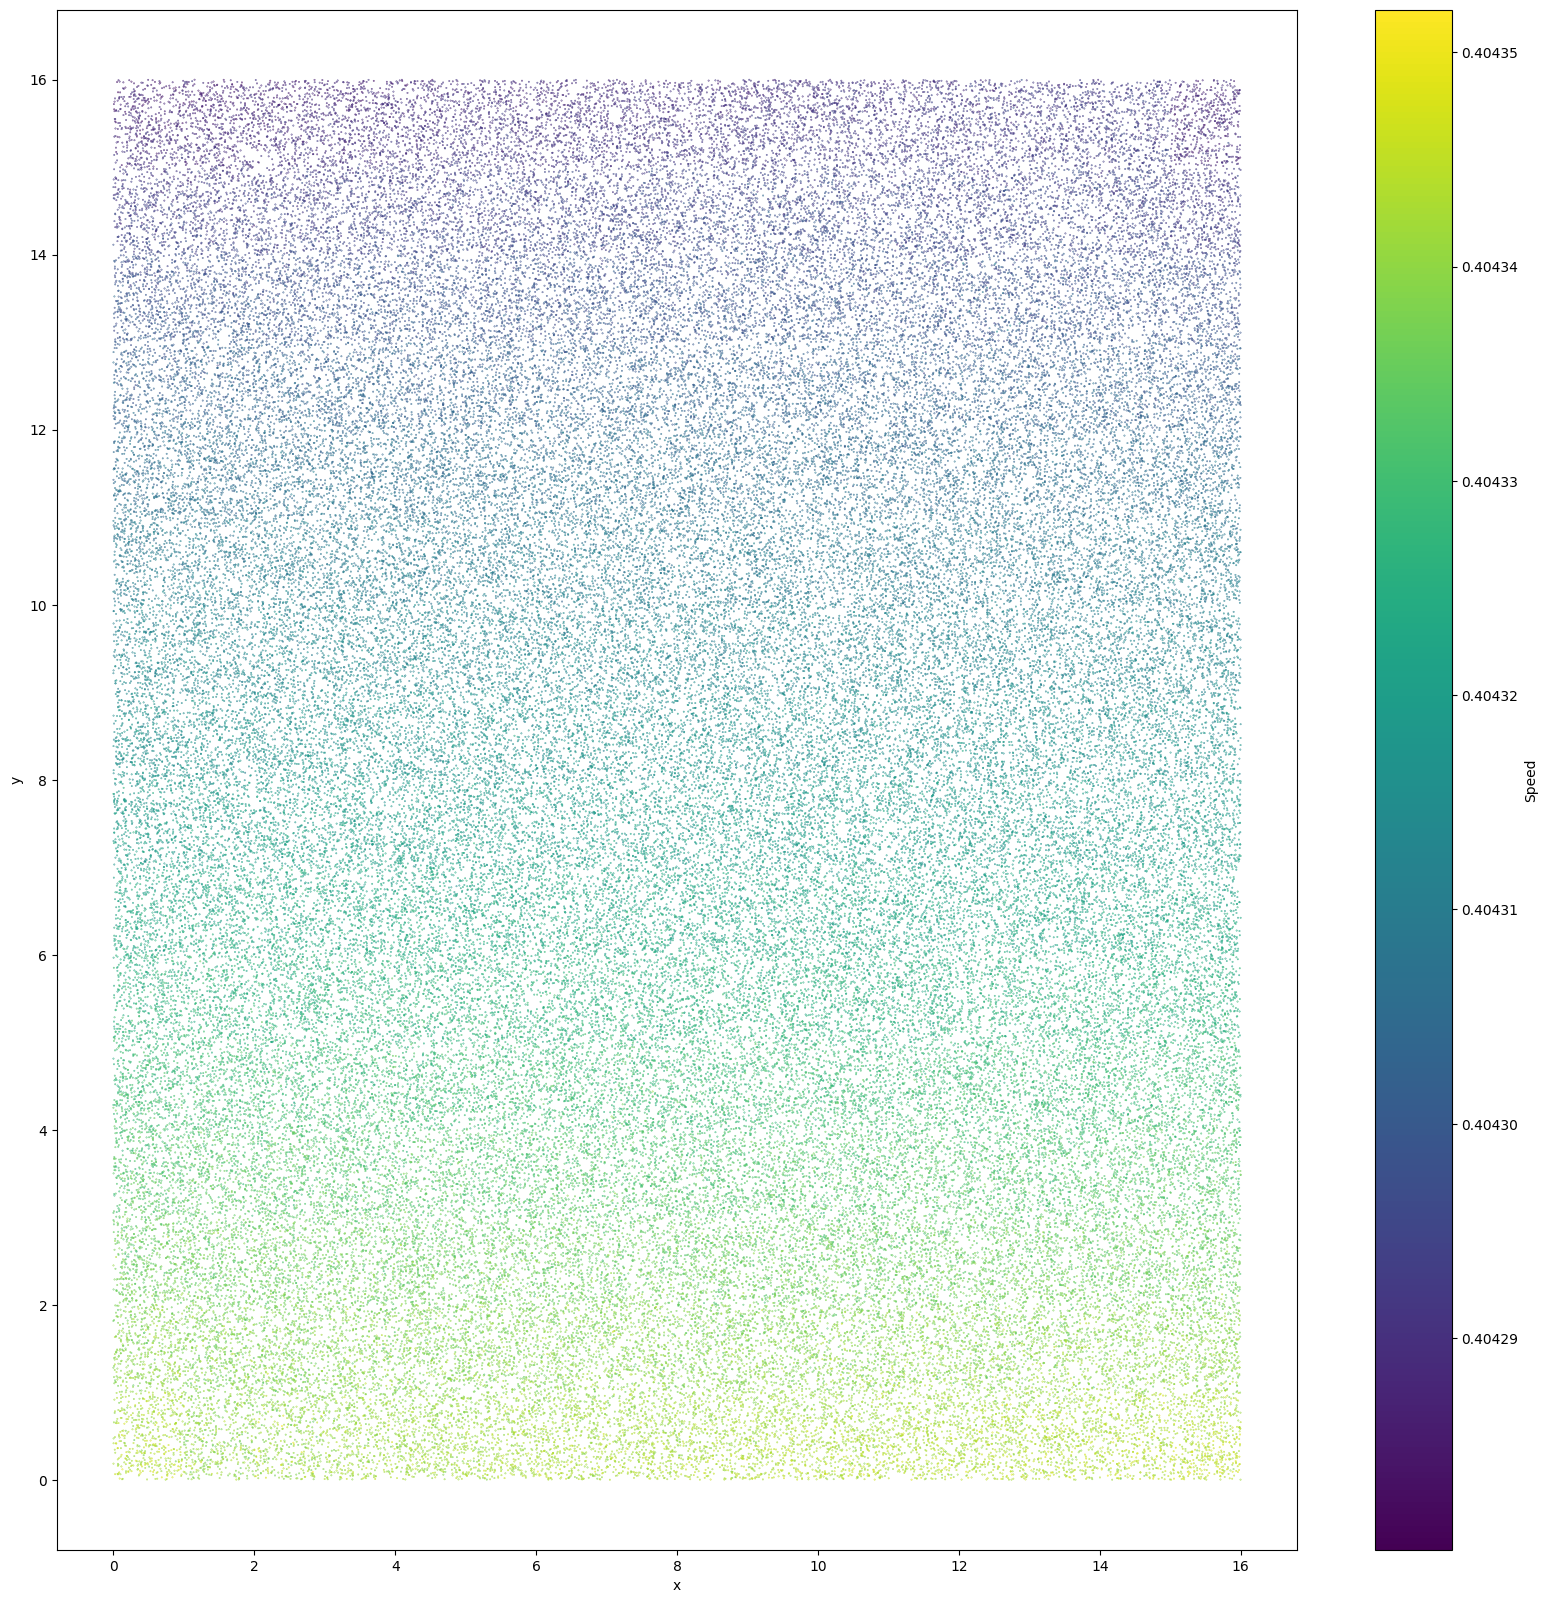

In [9]:
print(rs.shape, vs.shape)
speeds = np.sqrt(np.sum(vs ** 2, axis=1))
# plt.hist(speeds, bins=100)
# plt.show()
plt.subplots(figsize=(20,20))
# plt.hist2d(rs[:,0], rs[:,1], bins=1000)
plt.scatter(rs[:,0], rs[:,1], c=speeds, s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Speed')
plt.show()

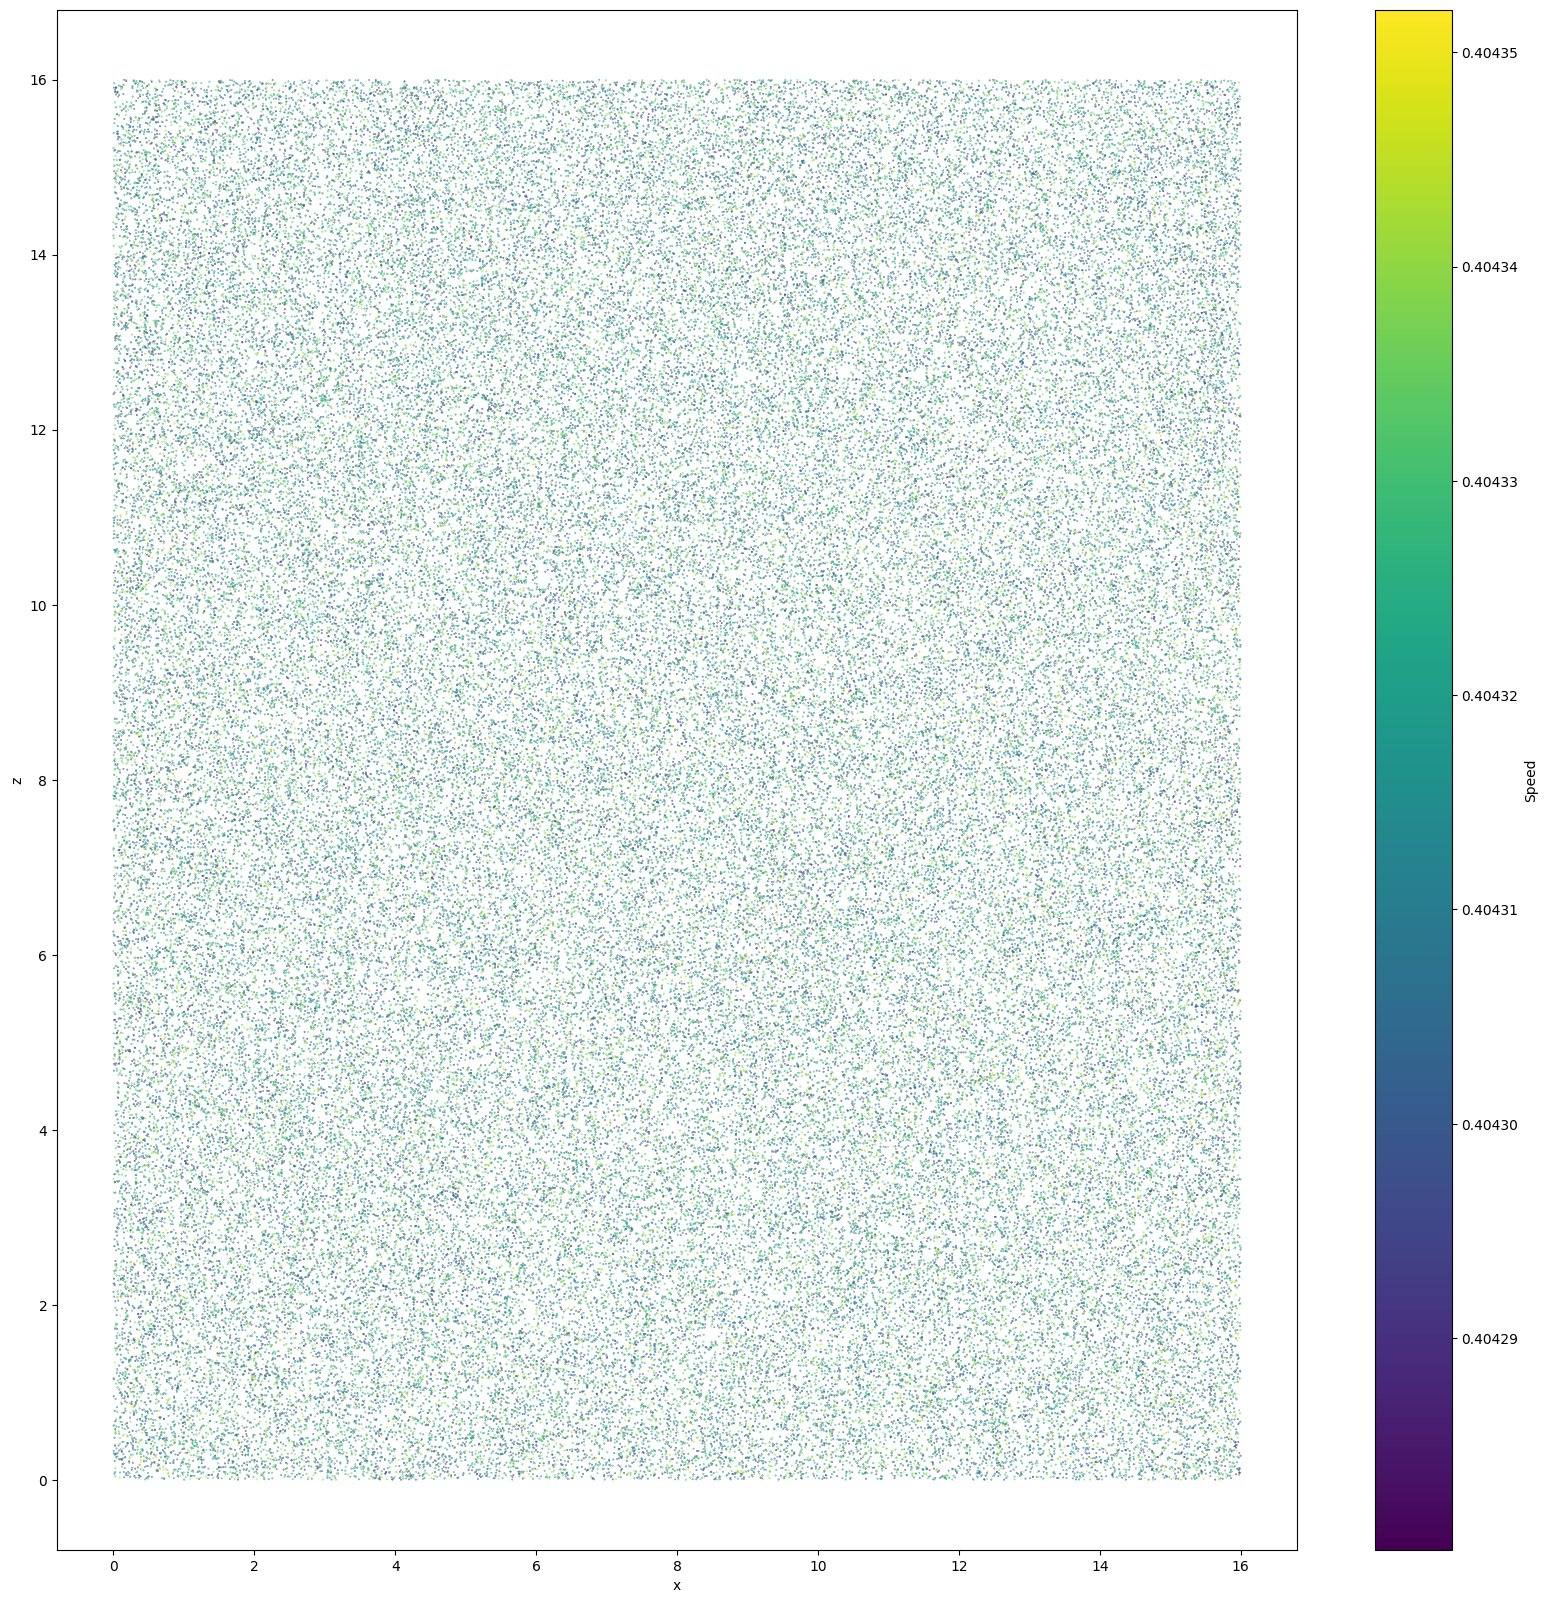

In [10]:
plt.subplots(figsize=(20,20))
# plt.hist2d(rs[:,0], rs[:,1], bins=1000)
plt.scatter(rs[:,0], rs[:,2], c=speeds, s=0.1)
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar(label='Speed')
plt.show()

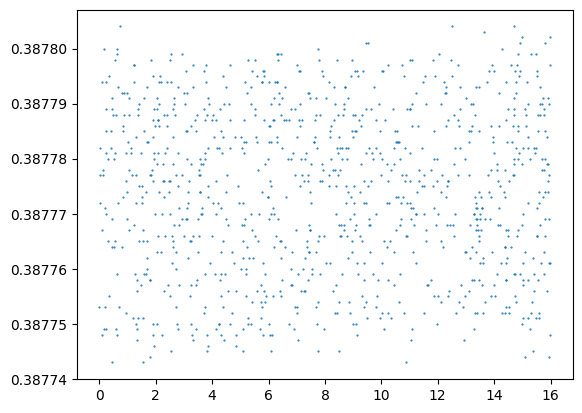

In [11]:
plt.scatter(rs[:1000,0], vs[:1000,0],s=0.3)